In [4]:
!pip install torch torchvision torchaudio
!pip install torch-geometric
!pip install networkx
!pip install scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.2 MB/s eta 0:00:00


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch_geometric
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


In [8]:
# Define the GCN model
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [ ]:
from torch_geometric.datasets import Planetoid

In [ ]:
dataset = Planetoid(root='/tmp/PubMed', name='PubMed')
data = dataset[0]

Processing...
Done!
/usr/local/lib/python3.10/dist-packages/torch_geometric/io/fs.py:215: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location)


In [9]:
# Initialize model parameters
input_dim = dataset.num_node_features
hidden_dim = 64
output_dim = dataset.num_classes

In [10]:
model = GCN(input_dim, hidden_dim, output_dim)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [11]:
# Define the training function
def train(data, model, optimizer, criterion, epochs=100):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

In [12]:
# Define the evaluation function
def evaluate(data, model):
    model.eval()
    out = model(data)
    _, pred = out[data.test_mask].max(dim=1)
    accuracy = accuracy_score(data.y[data.test_mask].numpy(), pred.numpy())
    return accuracy

In [13]:
 #Train the model
train(data, model, optimizer, criterion)

Epoch 0, Loss: 1.0980180501937866
Epoch 10, Loss: 0.8033158779144287
Epoch 20, Loss: 0.44004514813423157
Epoch 30, Loss: 0.20337912440299988
Epoch 40, Loss: 0.09071693569421768
Epoch 50, Loss: 0.04303789883852005
Epoch 60, Loss: 0.02342177741229534
Epoch 70, Loss: 0.014870637096464634
Epoch 80, Loss: 0.01060913410037756
Epoch 90, Loss: 0.008166485466063023


In [14]:
accuracy = evaluate(data, model)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.7600


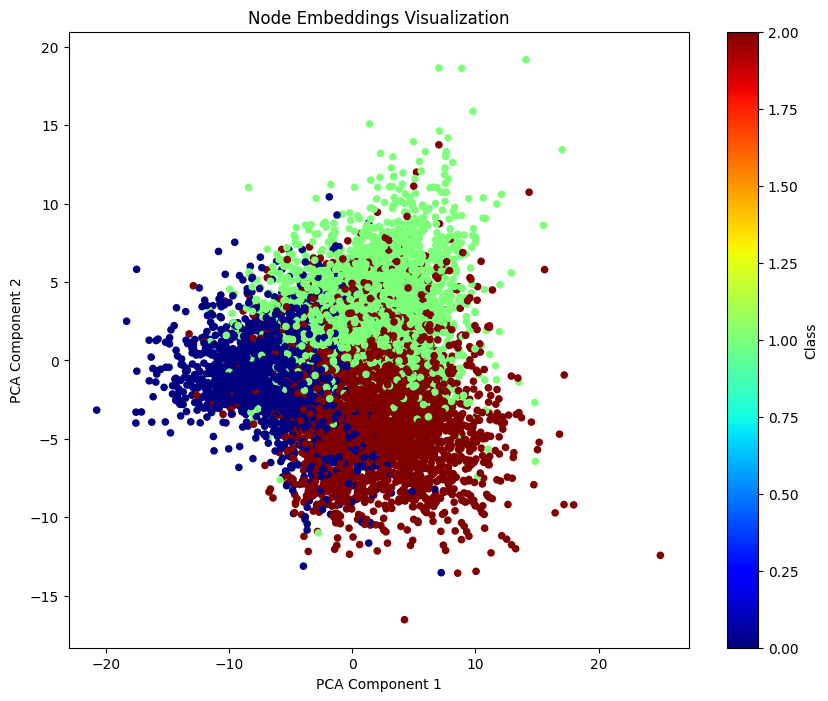

In [ ]:
from sklearn.decomposition import PCA

def visualize_node_embeddings(data, model):
    model.eval()
    out = model(data)
    embeddings = out.detach().cpu().numpy()

    # Reduce dimensions using PCA for visualization
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)

    # Plot the embeddings
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=data.y.cpu().numpy(), cmap='jet', s=20)
    plt.colorbar(scatter, label='Class')
    plt.title('Node Embeddings Visualization')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()

visualize_node_embeddings(data, model)


Epoch 0, Loss: 0.0027419873513281345
Epoch 10, Loss: 0.002384335733950138
Epoch 20, Loss: 0.002099370351061225
Epoch 30, Loss: 0.0018657154869288206
Epoch 40, Loss: 0.0016705862944945693
Epoch 50, Loss: 0.0015054348623380065
Epoch 60, Loss: 0.0013642212143167853
Epoch 70, Loss: 0.0012424173764884472
Epoch 80, Loss: 0.001136591425165534
Epoch 90, Loss: 0.001044010859914124


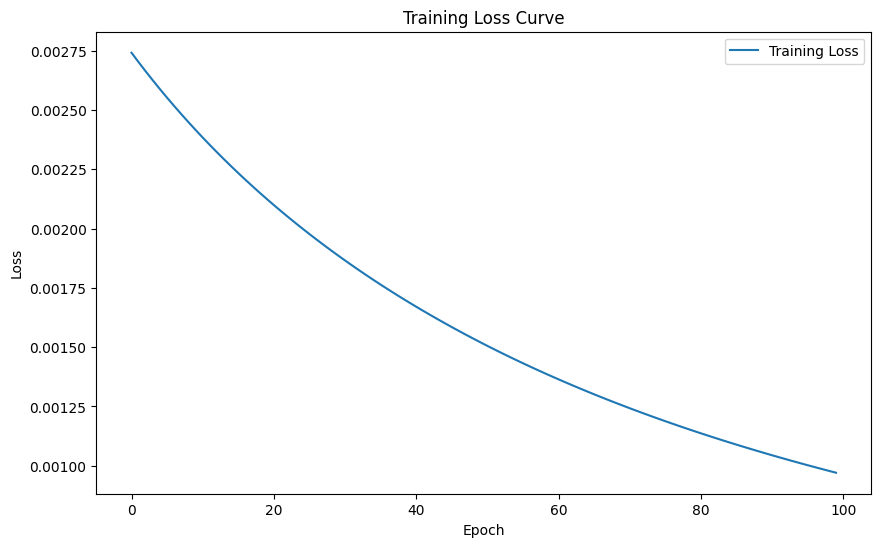

In [ ]:
def train_and_plot(data, model, optimizer, criterion, epochs=100):
    model.train()
    losses = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    # Plot training loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(epochs), losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

train_and_plot(data, model, optimizer, criterion)


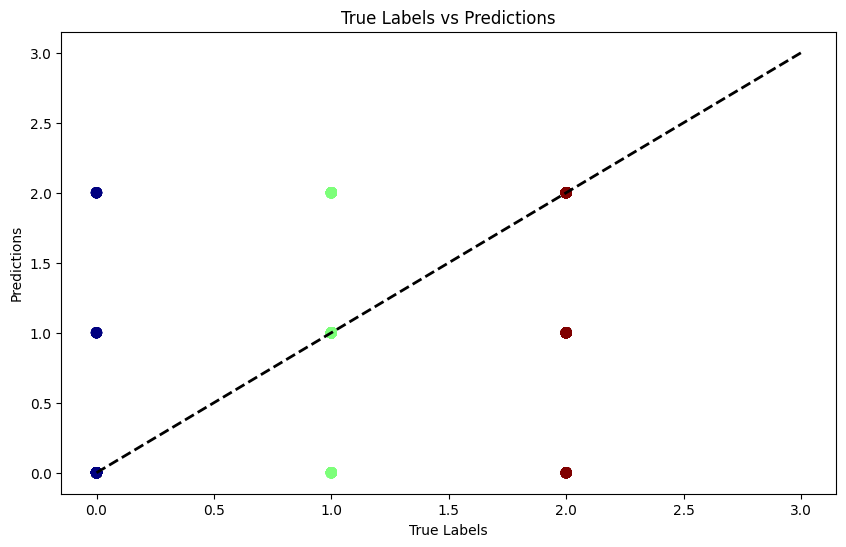

In [ ]:
def visualize_classification_results(data, model):
    model.eval()
    out = model(data)
    _, pred = out[data.test_mask].max(dim=1)

    # Convert tensor to numpy array for plotting
    true_labels = data.y[data.test_mask].cpu().numpy()
    predictions = pred.cpu().numpy()

    # Plotting true labels vs predictions
    plt.figure(figsize=(10, 6))
    plt.scatter(true_labels, predictions, c=true_labels, cmap='jet', s=50, alpha=0.7)
    plt.plot([0, len(set(true_labels))], [0, len(set(predictions))], 'k--', lw=2)
    plt.xlabel('True Labels')
    plt.ylabel('Predictions')
    plt.title('True Labels vs Predictions')
    plt.show()

visualize_classification_results(data, model)


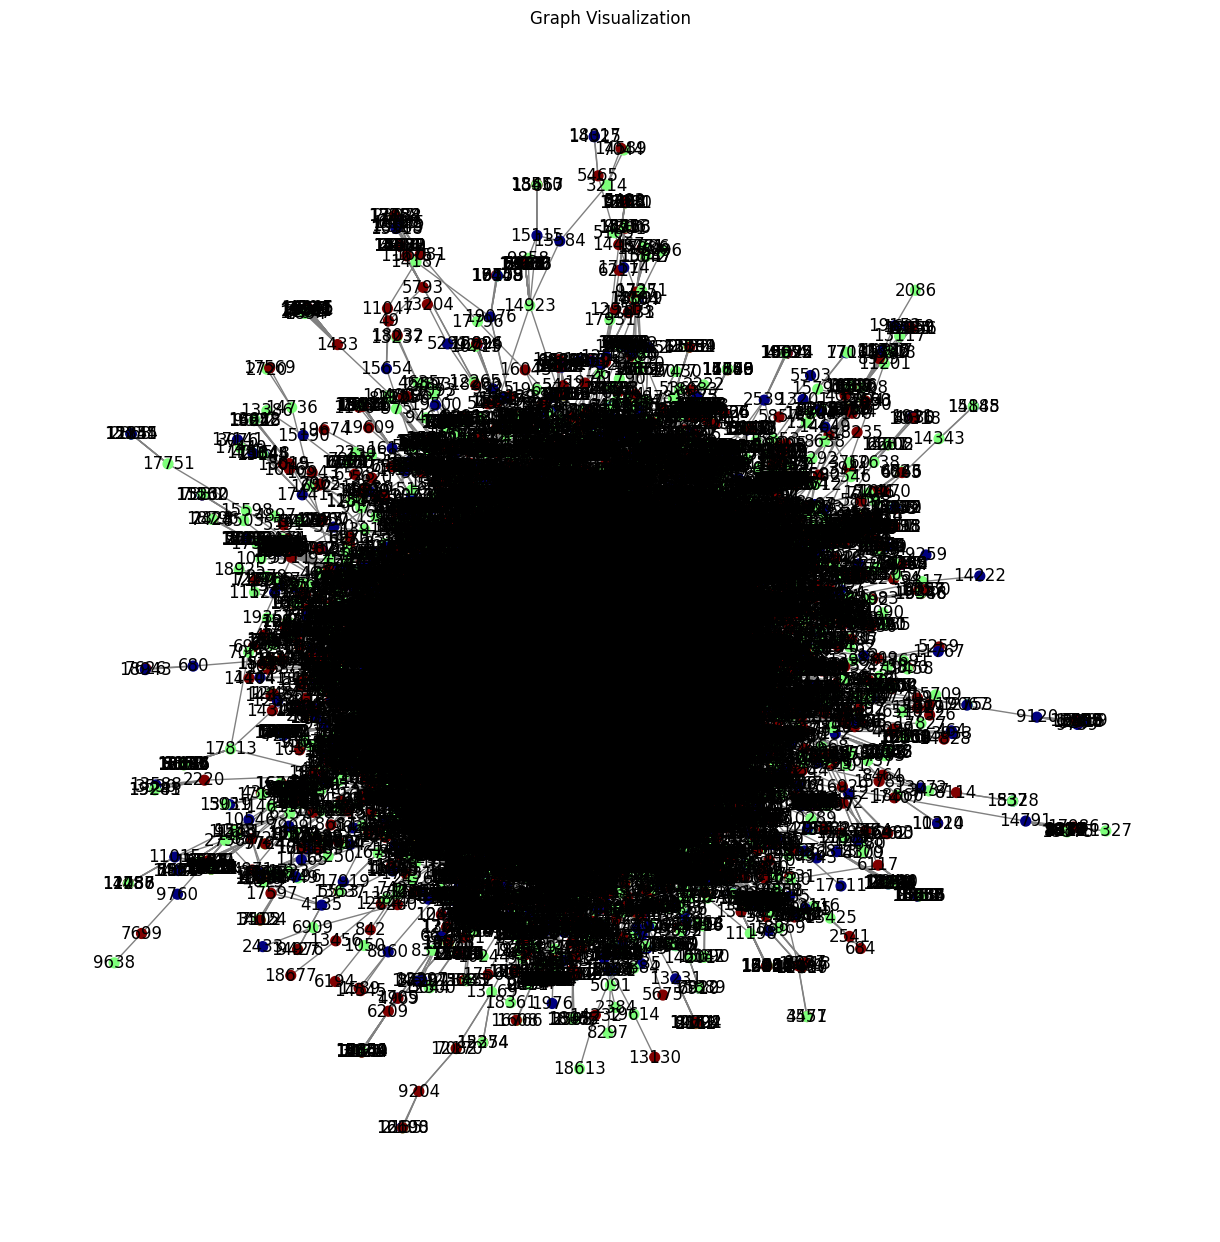

In [ ]:
import networkx as nx

def visualize_graph(data):
    edge_index = data.edge_index.numpy()
    edge_list = list(zip(edge_index[0], edge_index[1]))

    G = nx.Graph()
    G.add_edges_from(edge_list)

    node_colors = data.y.cpu().numpy()
    pos = nx.spring_layout(G)

    plt.figure(figsize=(12, 12))
    nx.draw(G, pos, node_color=node_colors, cmap='jet', with_labels=True, node_size=50, edge_color='gray')
    plt.title('Graph Visualization')
    plt.show()

visualize_graph(data)


In [5]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

# Load the PubMed dataset
dataset = Planetoid(root='/tmp/PubMed', name='PubMed', transform=NormalizeFeatures())
data = dataset[0]  # PubMed dataset contains only one graph


Processing...
Done!
/usr/local/lib/python3.10/dist-packages/torch_geometric/io/fs.py:215: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location)


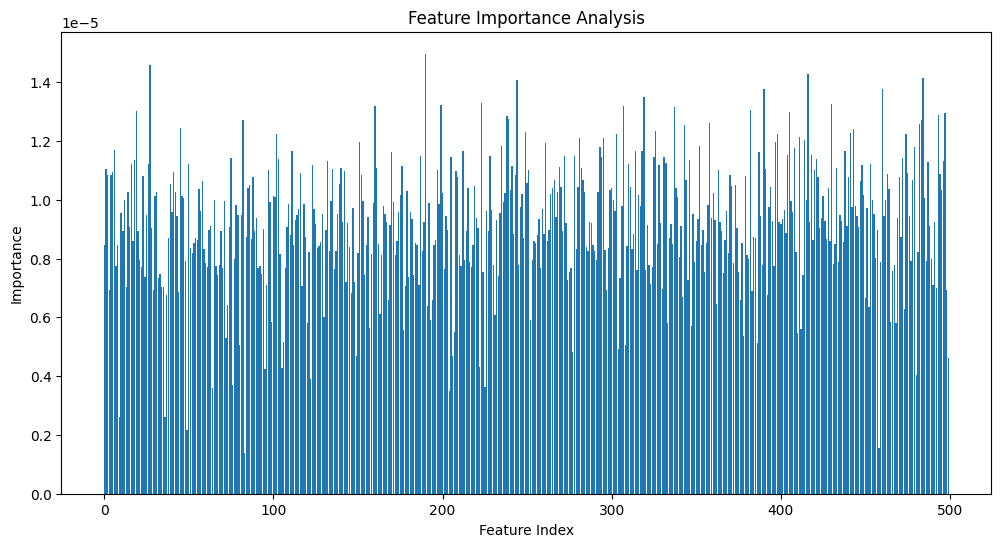

In [17]:
import numpy as np
import torch

def feature_importance_analysis(data, model):
    model.eval()

    # Enable gradient computation for node features
    data.x.requires_grad = True

    # Forward pass
    out = model(data)

    # Only consider the nodes in the training set for gradient calculation
    target = data.y[data.train_mask]
    out = out[data.train_mask]

    # Calculate the loss
    loss = torch.nn.CrossEntropyLoss()(out, target)

    # Backward pass to compute gradients
    loss.backward()

    # Extract gradients with respect to the input features
    feature_importances = np.abs(data.x.grad.cpu().numpy()).mean(axis=0)

    # Plot feature importances
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(feature_importances)), feature_importances)
    plt.title('Feature Importance Analysis')
    plt.xlabel('Feature Index')
    plt.ylabel('Importance')
    plt.show()

# Call the feature importance analysis function
feature_importance_analysis(data, model)
